# Markov Chains and Hidden Markov Models  

### George Tzanetakis, University of Victoria 

Trong sổ tay này, chúng ta sẽ khám phá các mô hình markov ẩn. Chúng tôi bắt đầu với các biến ngẫu nhiên và một mô hình phân bố giống hệt, độc lập đơn giản về thời tiết. Sau đó, chúng tôi xem xét cách hình thành Chuỗi Markov để chuyển đổi giữa các trạng thái và cuối cùng chúng tôi lấy mẫu Mô hình Markov ẩn để hiển thị cách tạo mẫu dựa trên Chuỗi Markov của các trạng thái ẩn. Các kết quả được hiển thị dưới dạng dải hình chữ nhật màu. Thử nghiệm xác suất chuyển tiếp và xác suất phát xạ để hiểu rõ hơn về cách Mô hình Markov ẩn hoạt động trong việc tạo dữ liệu. 


In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm

Trước tiên chúng ta hãy tạo một số mẫu ngẫu nhiên của biến ngẫu nhiên tượng trưng tương ứng với thời tiết với hai giá trị Nắng (S) và mây (C) và tạo thời tiết ngẫu nhiên trong 365 ngày. Giả định trong mô hình này là thời tiết mỗi ngày không phụ thuộc vào những ngày trước đó và được rút ra từ cùng một phân bố xác suất.

In [73]:
class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution 
        if all(type(item) is np.int64 for item in values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'): 
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def probs(self): 
        return self.probability_distribution
    
    def vals(self): 
        print(self.type)
        return self.values 

In [74]:
values = ['S', 'C']
probabilities = [0.5, 0.5]
weather = Random_Variable('weather', values, probabilities)
samples = weather.sample(365)

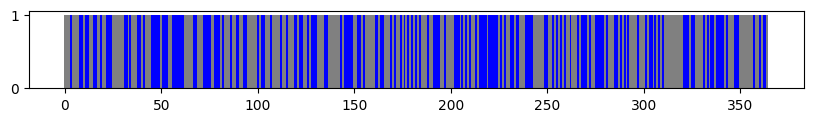

In [75]:
state2color = {} 
state2color['S'] = 'blue'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    
plot_weather_samples(samples, state2color)

Now instead of independently sampling the weather random variable lets form a markov chain. 

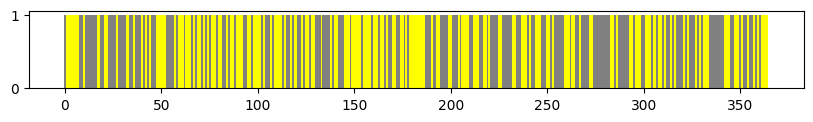

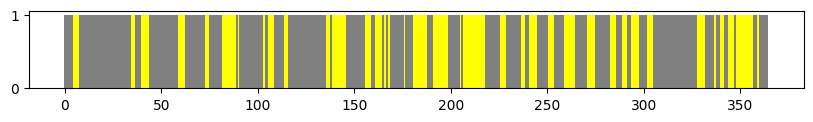

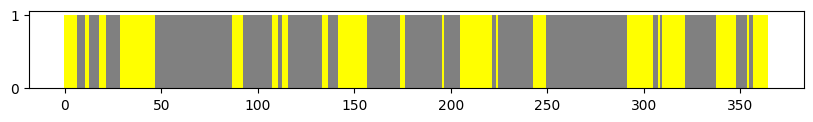

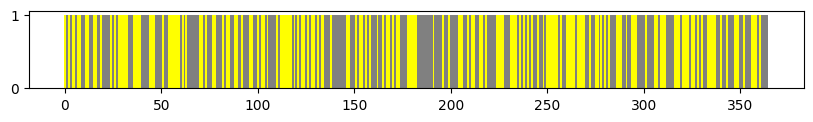

In [76]:
def markov_chain(transmat, state, state_names, samples): 
    (rows, cols) = transmat.shape 
    rvs = [] 
    values = list(np.arange(0,rows))
    
    # create random variables for each row of transition matrix 
    for r in range(rows): 
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)
    
    # start from initial state and then sample the appropriate 
    # random variable based on the state following the transitions 
    states = [] 
    for n in range(samples): 
        state = rvs[state].sample(1)[0]    
        states.append(state_names[state])
    return states


# transition matrices for the Markov Chain 
transmat1 = np.array([[0.7, 0.3], 
                    [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1], 
                    [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5], 
                     [0.5, 0.5]])



# plot the iid model too

state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'
samples = weather.sample(365)

plot_weather_samples(samples, state2color)

samples1 = markov_chain(transmat1,0,['S','C'], 365)
plot_weather_samples(samples1, state2color)

samples2 = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(samples2, state2color)

samples3 = markov_chain(transmat3,0,['S','C'], 365)
plot_weather_samples(samples3, state2color)


Lets now look at how a Hidden Markov Model would work by having a Markov Chain to generate 
a sequence of states and for each state having a different emission probability. When sunny we will output red or yellow with higher probabilities and when cloudy black or blue. First we will write the code directly and then we will use the hmmlearn package. 

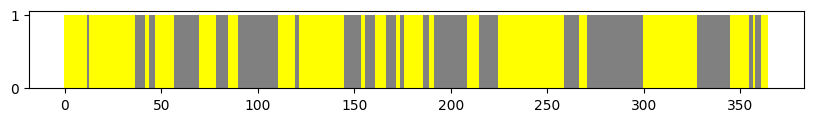

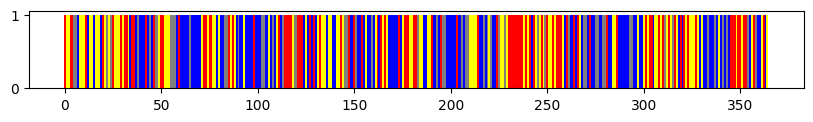

In [77]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'], 
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'], 
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors): 
    if (state == 'S'): 
        sample = sunny_colors.sample(1)[0]
    else: 
        sample = cloudy_colors.sample(1)[0]
    return sample 

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {} 
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)





In [78]:
# transmat = np.array([[0.9, 0.1], 
#                     [0.1, 0.9]])

# start_prob = np.array([1.0, 0.0, 0.0])

# # yellow and red have high probs for sunny 
# # blue and grey have high probs for cloudy 
# emission_probs = np.array([[0.4, 0.4, 0.1, 0.1], 
#                            [0.1, 0.1, 0.6, 0.2]])

# model = hmm.MultinomialHMM(n_components=2)
# model.startprob_ = start_prob 
# model.transmat_ = transmat 
# model.emissionprob_ = emission_probs

# # sample the model - X is the observed values 
# # and Z is the "hidden" states 
# X, Z = model.sample(365)

# state2color = {} 
# state2color[0] = 'yellow'
# state2color[1] = 'grey'
# plot_weather_samples(Z, state2color)

# samples = [item for sublist in X for item in sublist]

# state2color = {} 
# state2color[0] = 'yellow'
# state2color[1] = 'red'
# state2color[2] = 'blue'
# state2color[3] = 'grey'
# plot_weather_samples(samples, state2color)



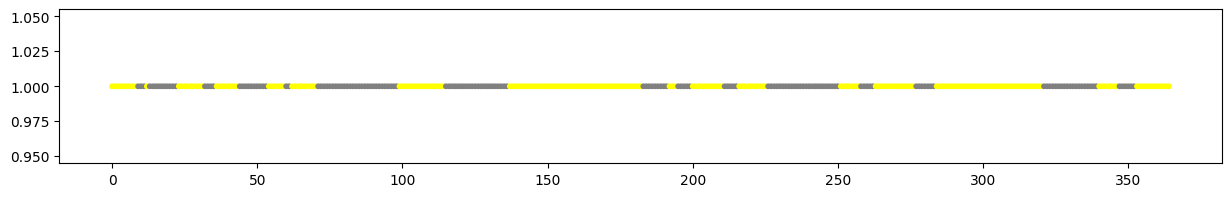

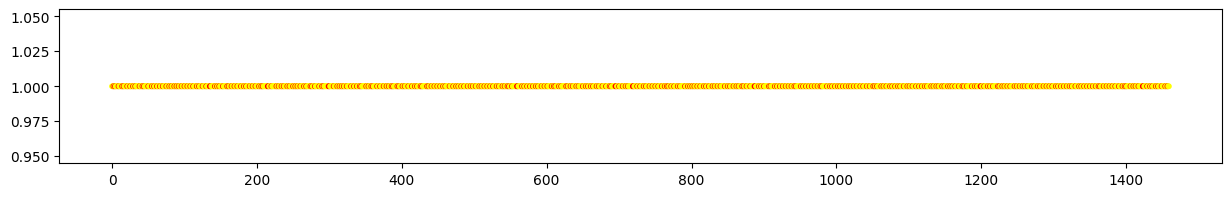

In [79]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Transition matrix for 2 states
transmat = np.array([[0.9, 0.1], 
                     [0.1, 0.9]])

# Start probabilities for 2 states
start_prob = np.array([1.0, 0.0])

# Emission probabilities
# Yellow and red have high probs for sunny 
# Blue and grey have high probs for cloudy 
emission_probs = np.array([[0.4, 0.4, 0.1, 0.1], 
                           [0.1, 0.1, 0.6, 0.2]])

# Create the HMM model with 2 states
model = hmm.MultinomialHMM(n_components=2, n_trials=1)  # Set n_trials here
model.startprob_ = start_prob 
model.transmat_ = transmat 
model.emissionprob_ = emission_probs

# Sample the model - X is the observed values and Z is the "hidden" states 
X, Z = model.sample(365)

# Define state to color mapping for plotting
state2color = {0: 'yellow', 1: 'grey'}

# Function to plot weather samples
def plot_weather_samples(states, state2color):
    colors = [state2color[state] for state in states]
    plt.figure(figsize=(15, 2))
    plt.scatter(range(len(states)), [1] * len(states), c=colors, s=10)
    plt.show()

plot_weather_samples(Z, state2color)

# Flatten the samples
samples = [item for sublist in X for item in sublist]

# Update the state2color mapping for the observed values
state2color = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'grey'}

plot_weather_samples(samples, state2color)


# Gaussian HMM



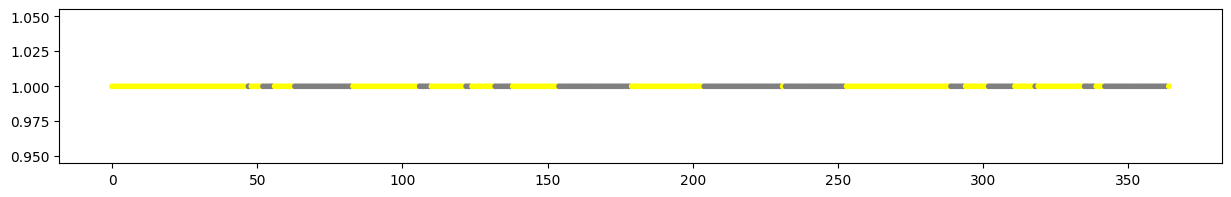

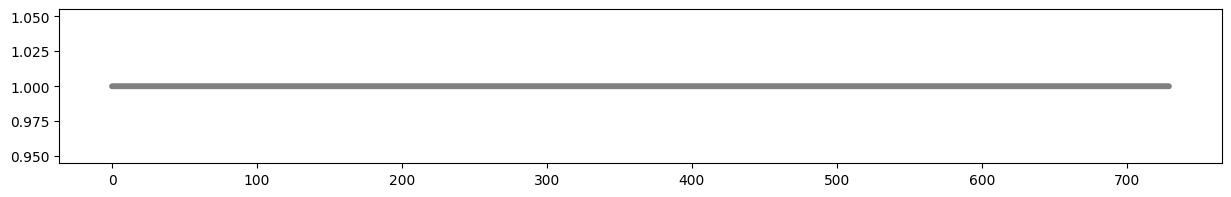

In [92]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Ma trận chuyển trạng thái cho 2 trạng thái
transmat = np.array([[0.9, 0.1],
                     [0.1, 0.9]])

# Xác suất khởi đầu cho 2 trạng thái
start_prob = np.array([1.0, 0.0])

# Giá trị trung bình và hiệp phương sai của phân phối Gaussian cho 2 trạng thái
means = np.array([[25.0, 15.0],
                  [15.0, 25.0]])  # Giá trị trung bình nhiệt độ cho trời nắng và trời âm u
covars = np.tile(np.identity(2), (2, 1, 1))  # Ma trận hiệp phương sai đường chéo

# Tạo mô hình Gaussian HMM với 2 trạng thái
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1)
model.startprob_ = start_prob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

# Mô phỏng mô hình - X là các giá trị quan sát và Z là các trạng thái "ẩn"
X, Z = model.sample(365)

# Định nghĩa ánh xạ từ trạng thái đến màu sắc để vẽ biểu đồ
state2color = {0: 'yellow', 1: 'grey'}

# Hàm để vẽ mẫu thời tiết
# Hàm để vẽ mẫu thời tiết với xử lý lỗi
def plot_weather_samples(states, state2color):
    colors = []
    default_color = 'grey'  # Giá trị mặc định nếu không có ánh xạ cho trạng thái
    for state in states:
        try:
            color = state2color[state]
        except KeyError:
            color = default_color
        colors.append(color)
    plt.figure(figsize=(15, 2))
    plt.scatter(range(len(states)), [1] * len(states), c=colors, s=10)
    plt.show()

# Vẽ biểu đồ cho các mẫu thời tiết với xử lý lỗi
plot_weather_samples(Z, state2color)

# Gộp các mẫu
samples = [item for sublist in X for item in sublist]

# Cập nhật ánh xạ state2color cho các giá trị quan sát
state2color = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'grey'}

# Vẽ biểu đồ cho các mẫu
plot_weather_samples(samples, state2color)



# Kalman

In [3]:
import numpy as np
from pykalman import KalmanFilter

# Tạo một bộ lọc Kalman
kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])

# Điều chuẩn hóa các giá trị Nắng và Mây
weather_patterns = np.where(weather_patterns == 'S', 1, 0)

# Thực hiện bộ lọc Kalman
measurements = np.eye(2)[weather_patterns]
kf = kf.em(measurements, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
predicted_weather[:365] = np.argmax(filtered_state_means, axis=1)

# Xuất kết quả
print(predicted_weather)

['1' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0